In [24]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
 <a href="javascript:code_toggle()">expand</a>.''')

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.options.display.max_rows = 999
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices

In [3]:
FeatureTrain = pd.read_csv('./data/dengue_features_train.csv',parse_dates = ['week_start_date'])
TargetTrain = pd.read_csv('./data/dengue_labels_train.csv' )
FeatureTest = pd.read_csv('./data/dengue_features_test.csv',parse_dates = ['week_start_date'])
Answersheet = pd.read_csv('./data/submission_format.csv' )

#                                  Presentation Data Exploration

In [4]:
panel = TargetTrain.merge(FeatureTrain,on = ['city','year','weekofyear'] ,how = 'outer') 
 
kelvin = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',   \
          'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k','reanalysis_dew_point_temp_k']
panel.loc[:,kelvin] = panel.loc[:,kelvin]-273.15# kelvin to C
FeatureTest.loc[:,kelvin] =FeatureTest.loc[:,kelvin]-273.15# kelvin to C
panel.columns
timeid = ['year', 'weekofyear']
green = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']
precipitation  =['precipitation_amt_mm','reanalysis_sat_precip_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2',]
avg_temp = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',  'station_avg_temp_c' ]
min_temp = ['station_min_temp_c','reanalysis_min_air_temp_k']
max_temp = ['station_max_temp_c','reanalysis_max_air_temp_k']
dtr =  ['reanalysis_tdtr_k', 'station_diur_temp_rng_c']
humid = ['reanalysis_dew_point_temp_k','reanalysis_specific_humidity_g_per_kg', 'reanalysis_relative_humidity_percent']
selected = humid + dtr + max_temp +min_temp +avg_temp +precipitation +timeid+green + ['city','total_cases','week_start_date']
features_selected= humid + dtr + max_temp +min_temp +avg_temp +precipitation +timeid+green  
panel = panel.loc[:,selected]

 
 
 

In [6]:
city_name = 'sj'
def get_data_panel(panel,city_name):
    panel_train =  panel.loc[panel.city == city_name].interpolate()  .set_index('week_start_date').copy().drop(['city'],axis = 1).copy()
    
    panel_test = FeatureTest.loc[FeatureTest.city == city_name].interpolate().set_index('week_start_date').copy().drop('city',axis = 1)
    panel_test['total_cases'] = np.nan 
    train_len = len(panel_test['total_cases'])
    panel = pd.concat([panel_train,panel_test],sort = False)
    
    
    panel['green_s']  = panel.loc[:,green[:2]].mean(1)
    panel['green_n']  = panel.loc[:,green[2:]].mean(1) 
    panel['green']  = panel.loc[:,green ].mean(1) 

    panel  = panel 
    return panel,train_len

panel_sj,len_sj = get_data_panel(panel,'sj')
panel_iq,len_iq = get_data_panel(panel,'iq')

def min_max(data):
     
    return (data - data.min())/(data .max()- data.min())
    

## Discribe data
 
#### 1. Target: total cases comfirmed Dengue fever cases weekly
#### 2. Features:
    1. Weekly Climate / environment data for San Juan(SJ) and Iquitos(IQ)
    2. Data can be catigorized by temperature(min/max/average), humidity,temperature range, precipitation
      and vagitation
    3. There are two schools (reanalysis(Theory recalculated) and measurement) for one climate variable.They are similar some even 
      duplicated. 
#### 3. dataset:
    1. For SJ, Train/Test(for submission) size is 936/260.(1990/04/30 - 2008/04/22 and 2008/04/29 - 2013/04/23) 
    2. For IQ, Train/Test(for submission) size is 520/156.(2000/07/01 - 2010/06/25 and 2010/07/02 - 2013/06/25)
    4. Missing values:not too much missing value over all except ndvi_ne and ndvi_sw.

## Explore data

### Targets

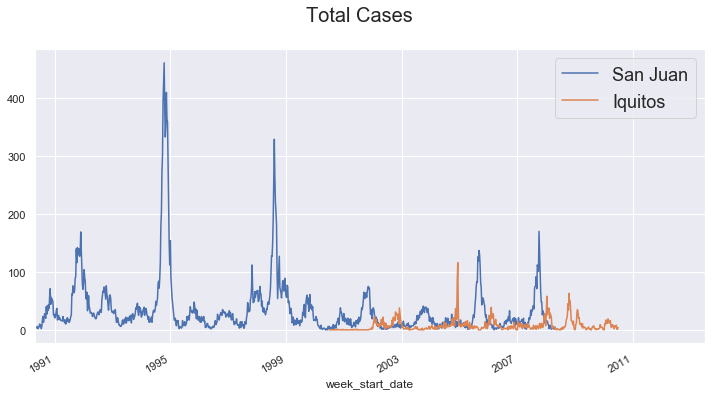

In [7]:
 
fig = plt.figure(figsize = (12,6) )
fig.suptitle('Total Cases', fontsize=20)
panel_sj.total_cases .plot( )
panel_iq .total_cases .plot()
plt.legend(['San Juan','Iquitos'],fontsize = 18)


### Targets(Cont.):
    1. They are differed in scale and have some overlapping in time 
    2. First 60 data for IQ are 0, it is considered very from other observations
    3. The plots show strong seasonality. Peaks are much higher than usual values.So predicting these outlier is of same importance.
    4. SJ is decrease in scale while IQ is incrasing. This might relate to population informations
    
    
    

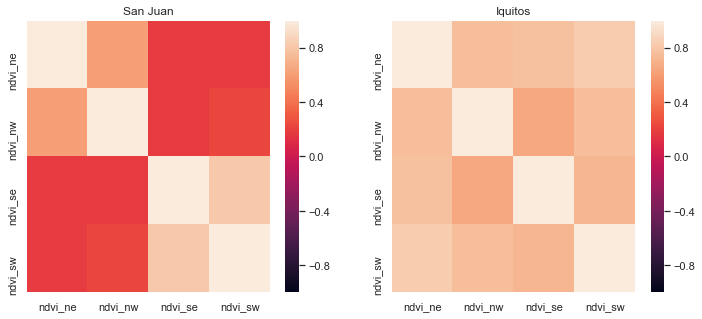

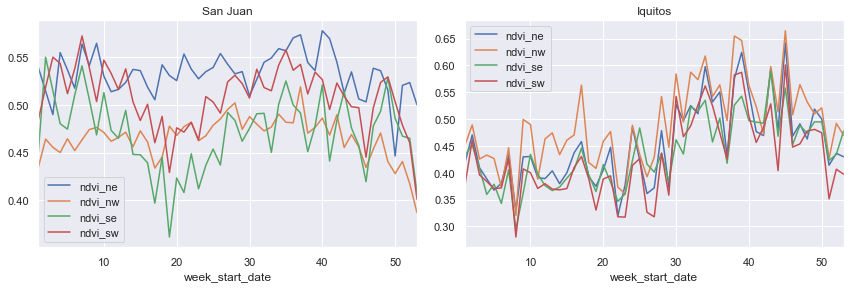

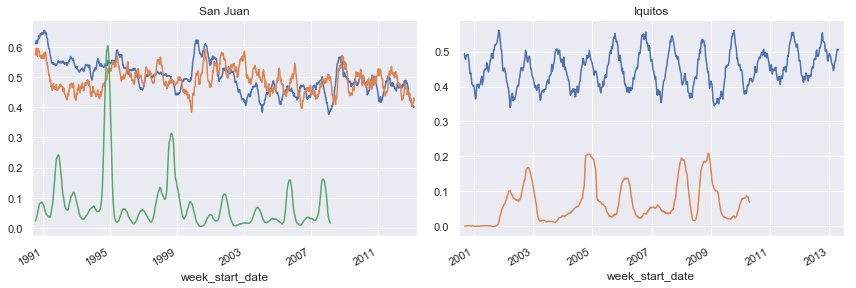

In [8]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,green].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,green].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')


"""
Seasonality of green:
 

"""

f, axes = plt.subplots(1, 2,figsize = (12,4))

min_max(panel_sj).loc[:,green].groupby(min_max(panel_sj).index.week).mean() .plot(ax =axes[0])

min_max(panel_iq).loc[:,green].groupby(min_max(panel_iq).index.week).mean()  .plot(ax =axes[1])
plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')


"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,green[:2]].mean(1).rolling(20,center = True).mean() .plot(ax =axes[0])
min_max(panel_sj).loc[:,green[2: ]].mean(1).rolling(20,center = True).mean() .plot(ax =axes[0])
cases = ((min_max(panel_sj).loc[:,'total_cases']  )  ).rolling(20,center = True).mean()
cases =( cases  )
cases .plot(ax =axes[0])




min_max(panel_iq).loc[:,green].mean(1).rolling(20,center = True) .mean()  .plot(ax =axes[1])
cases = ((min_max(panel_iq).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
cases =( cases  )
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

### Vagitation:
    1. For SJ, vagitation in the south are similr. while for IQ they are highly correlated - take avarage to reduce noise/fill na
    2. Vagitation is non - stationary vs stationary total cases. Difference may need to be done
   

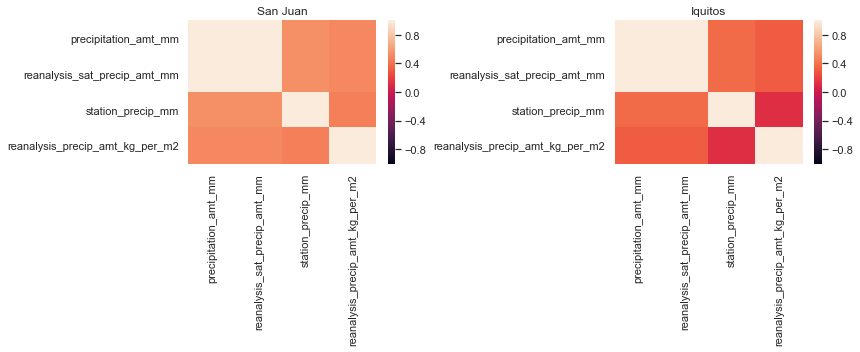

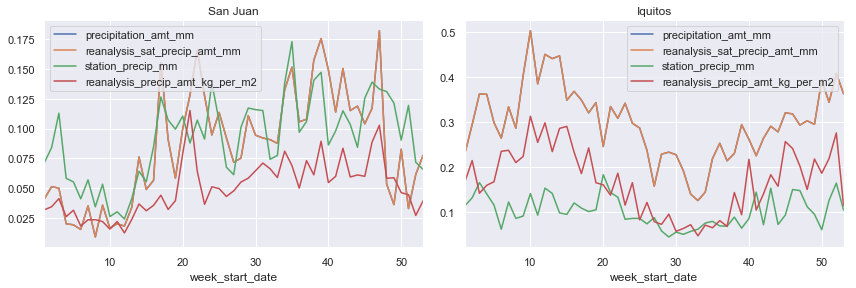

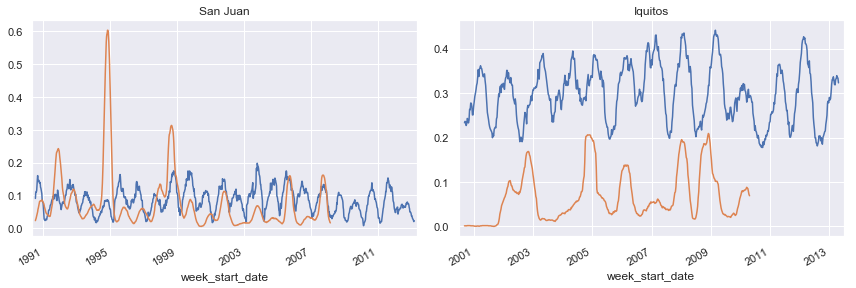

In [9]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,precipitation].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,precipitation].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

plt.tight_layout()
"""
Seasonality of precipitation:
 

"""

f, axes = plt.subplots(1, 2,figsize = (12,4))

min_max(panel_sj).loc[:,precipitation].groupby(min_max(panel_sj).index.week).mean() .plot(ax =axes[0])

min_max(panel_iq).loc[:,precipitation].groupby(min_max(panel_iq).index.week).mean()  .plot(ax =axes[1])
plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')


"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,precipitation[:2]].mean(1).rolling(20,center = True).mean() .plot(ax =axes[0])
cases = ((min_max(panel_sj).loc[:,'total_cases']  )  ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq).loc[:,precipitation[:2]].mean(1).rolling(20,center = True).mean() .plot(ax =axes[1])
cases = ((min_max(panel_iq).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

### precipitation
    1. The seasonality of precipitation actually predict quite well that of total cases'.  
    2. There is counter example in 1995 for San Juan, using this sample may produce negtive impack, should we remove this time period?
    3. Moreover, it might be not reasonable to measure correlation between feature and target, given their non-stationality

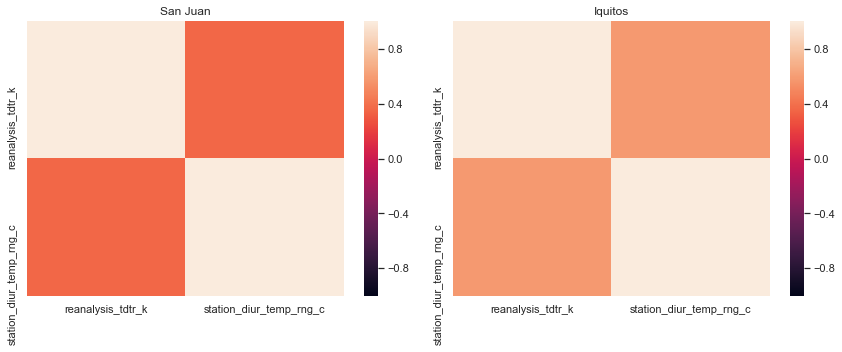

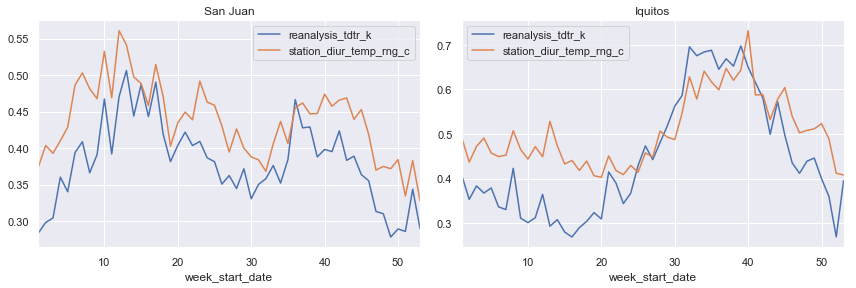

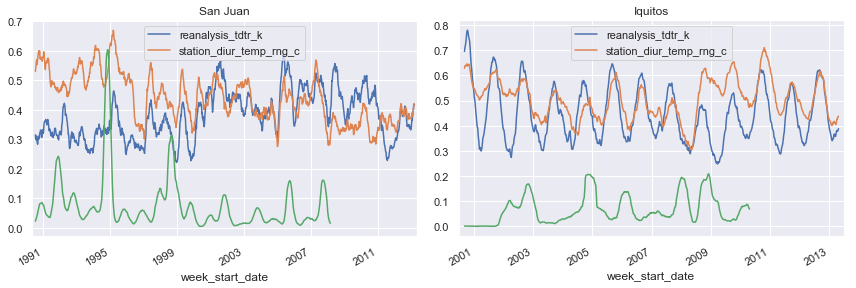

In [10]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,dtr].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,dtr].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

plt.tight_layout()
"""
Seasonality of dtr:
 

"""

f, axes = plt.subplots(1, 2,figsize = (12,4))

min_max(panel_sj).loc[:,dtr].groupby(min_max(panel_sj).index.week).mean() .plot(ax =axes[0])

min_max(panel_iq).loc[:,dtr].groupby(min_max(panel_iq).index.week).mean()  .plot(ax =axes[1])
plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')


"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,dtr ] .rolling(20,center = True).mean() .plot(ax =axes[0])
 
cases = ((min_max(panel_sj).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq).loc[:,dtr ] .rolling(20,center = True).mean() .plot(ax =axes[1])
 
cases = ((min_max(panel_iq).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

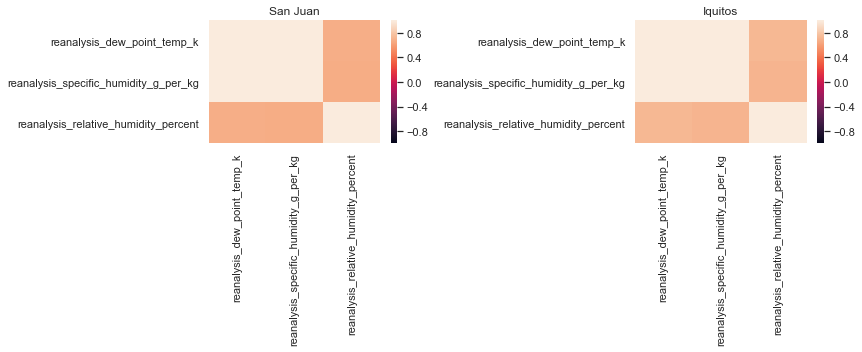

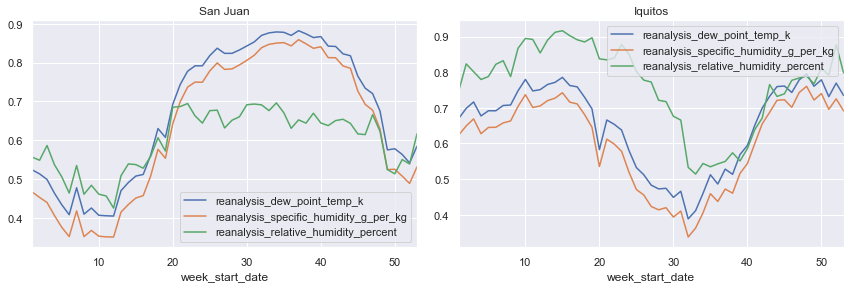

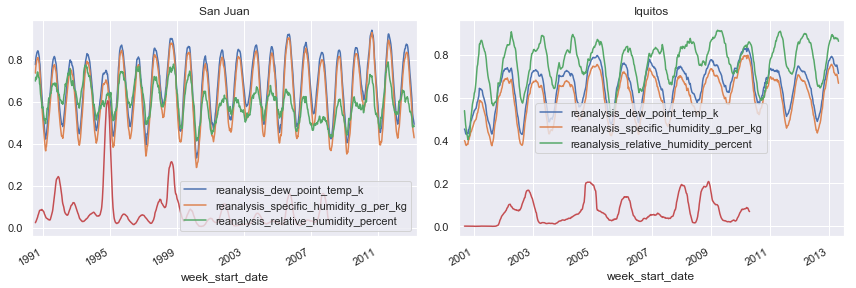

In [11]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,humid].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,humid].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

plt.tight_layout()
"""
Seasonality of humid:
 

"""

f, axes = plt.subplots(1, 2,figsize = (12,4))

min_max(panel_sj).loc[:,humid].groupby(min_max(panel_sj).index.week).mean() .plot(ax =axes[0])

min_max(panel_iq).loc[:,humid].groupby(min_max(panel_iq).index.week).mean()  .plot(ax =axes[1])
plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')


"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,humid ] .rolling(20,center = True).mean() .plot(ax =axes[0])
 
cases = ((min_max(panel_sj).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq).loc[:,humid ] .rolling(20,center = True).mean() .plot(ax =axes[1])
 
cases = ((min_max(panel_iq).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

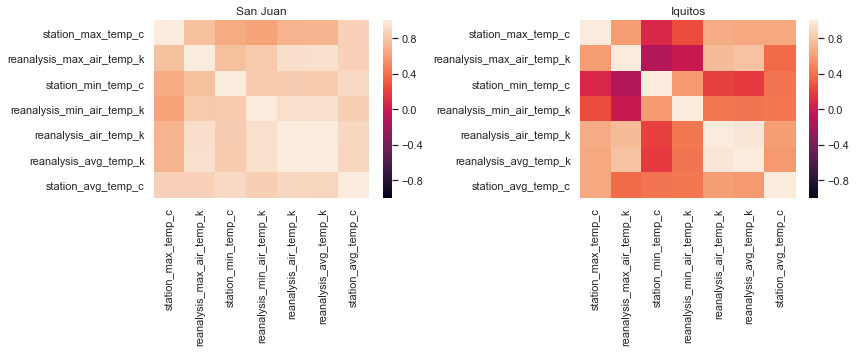

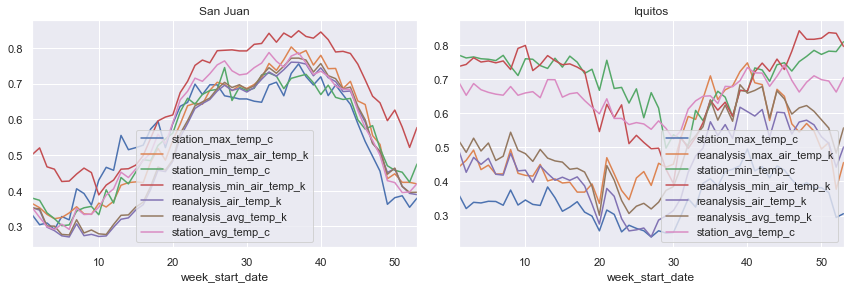

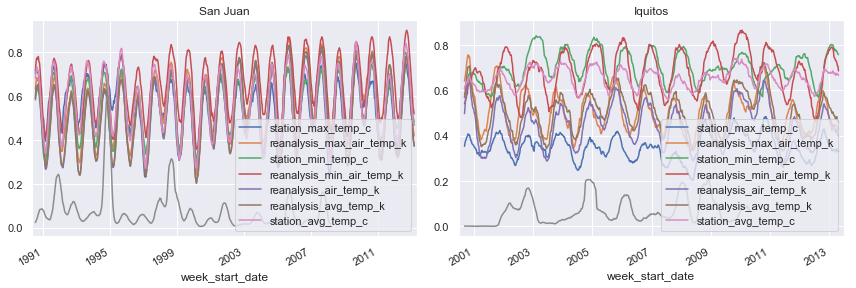

In [12]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,max_temp + min_temp + avg_temp].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,max_temp + min_temp + avg_temp].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

plt.tight_layout()
"""
Seasonality of max_temp + min_temp + avg_temp:
 

"""

f, axes = plt.subplots(1, 2,figsize = (12,4))

min_max(panel_sj).loc[:,max_temp + min_temp + avg_temp].groupby(min_max(panel_sj).index.week).mean() .plot(ax =axes[0])

min_max(panel_iq).loc[:,max_temp + min_temp + avg_temp].groupby(min_max(panel_iq).index.week).mean()  .plot(ax =axes[1])
plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')


"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,max_temp + min_temp + avg_temp ] .rolling(20,center = True).mean() .plot(ax =axes[0])
 
cases = ((min_max(panel_sj).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq).loc[:,max_temp + min_temp + avg_temp ] .rolling(20,center = True).mean() .plot(ax =axes[1])
 
cases = ((min_max(panel_iq).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

### Some thoughts
    1. Person correlation wouldn't tell much story aside from seasonality
    2. Given the comlexity of trend/seasonality/ jump blended, it might not be reasonable to directly modified original factors
    3. We can use rank correlation after de-seasoning

# Features vs Target

## Given the seasonality, it is hard to indentify "real correlation"
I will de-season and calculate correlation then

In [14]:
series = panel_sj.loc[:,'total_cases']
def de_season_tri(series):
    
    target = series.name
    series = pd.DataFrame(series.copy())
    series["season_sin"] = np.sin(series.index.weekofyear/53*6.2831)
    series["season_cos"] = np.cos(series.index.weekofyear/53*6.2831)


    X_out = series.drop(target,axis = 1) 
    X_out  = sm.add_constant(X_out) 




    train_df = series.dropna()
    train_y = train_df  .loc[:,target]
    train_y =train_y.clip(train_y.quantile(0.01),train_y.quantile(0.9))
    train_X = train_df  .drop(target,axis = 1)
    train_X = sm.add_constant(train_X)
    model = sm.OLS(train_y,train_X)
    res = model.fit()
    return  series.loc[:,target] .ravel()/res  .predict(X_out) .ravel() - 1

panel_sj_ds = panel_sj.apply(de_season_tri,axis = 0)
panel_iq_ds = panel_iq.apply(de_season_tri,axis = 0)

D:\Anaconda3\envs\interview_env\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Now Let's see how it looks after de-seasoning:
    -with temperature for Example: we can see more clearly about their realationship

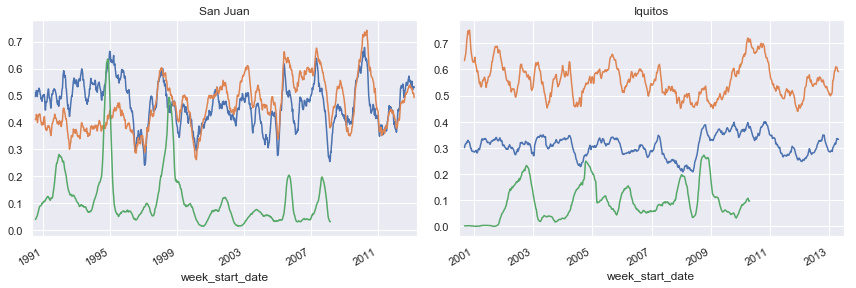

In [20]:
"""
See how it goes after de-season
max_temp + min_temp + avg_temp 
humid
green
precipitation
dtr
"""
selected_features = max_temp
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj_ds).loc[:,selected_features ] .rolling(20,center = True).mean()  .plot(ax =axes[0], legend=False) 
 
cases = ((min_max(panel_sj_ds).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq_ds).loc[:,selected_features  ] .rolling(20,center = True).mean()  .plot(ax =axes[1], legend=False)
 
cases = ((min_max(panel_iq_ds).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

## Brute Force Feature selection: Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

drops = ['reanalysis_specific_humidity_g_per_kg']  + green +\
['reanalysis_sat_precip_amt_mm','reanalysis_avg_temp_k','year','weekofyear','total_cases'] 
 
panel_sj_selected  = panel_sj.loc[:,['total_cases']]
panel_iq_selected  = panel_iq.loc[:,['total_cases']] 

def append_shift(left,right,selected,shift,smooth =52):
    new_names = []
    right = right.copy().apply(lambda x : x.clip(0,x.quantile(0.9)),axis = 0)
    for name in selected:
        new_name = name + '_shift_' +str(shift)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth    ).mean().shift(shift).loc[:,name ]
    return left

def append_diff(left,right,selected,diff,smooth =52):
    new_names = []
    right = right.copy().apply(lambda x : x.clip(0,x.quantile(0.9)),axis = 0)
    for name in selected:
        new_name = name + '_diff_' +str(diff)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth    ).mean().diff(diff).loc[:,name ]
    return left


def append_diff(left,right,selected,diff,smooth =52):
    new_names = []
    right = right.copy().apply(lambda x : x.clip(0,x.quantile(0.9)),axis = 0)
    for name in selected:
        new_name = name + '_diff_' +str(diff)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth    ).mean().diff(diff).loc[:,name ]
    return left



def data_process(panel,panel_candidate ):
    
    """
    Make sure it is at least forward filled
    """
    
    panel = append_shift(panel,panel_candidate,\
          panel_candidate.columns,0,52)
    
    panel = append_shift(panel,panel_candidate,\
          panel_candidate.columns,0,20)
    
    panel = append_diff(panel,panel_candidate,\
          panel_candidate.columns,52,20)
    
    
    # de - seasons
    de_seasons = panel_candidate.apply(de_season_tri,axis = 0)
    new_names = [name +'_ds' for name in de_seasons.columns]
    de_seasons.columns = new_names
    
    
    panel = append_shift(panel,de_seasons,\
          de_seasons.columns,0,52)
    
    panel = append_shift(panel,de_seasons,\
          de_seasons.columns,0,20)
    
    panel = append_diff(panel,de_seasons,\
          de_seasons.columns,52,20)
    
    
    
 
 
    
    return panel 



panel_sj_selected =  data_process(panel_sj_selected,panel_sj.drop(drops,axis = 1))
panel_iq_selected =  data_process(panel_iq_selected,panel_iq.drop(drops,axis = 1)) 


train_y_sj, train_X_sj =   panel_sj_selected  .iloc[: -len_sj].dropna().loc[:,'total_cases'],\
                            panel_sj_selected .iloc[: -len_sj] .dropna().drop('total_cases',axis = 1)  
 
train_y_iq, train_X_iq =   panel_iq_selected .iloc[60: -len_iq].dropna() .loc[:,'total_cases'],\
                            panel_iq_selected.iloc[60: -len_iq] .dropna() .drop('total_cases',axis = 1)  
                         

test_X_sj = panel_sj_selected.drop('total_cases',axis = 1)  .iloc[-len_sj: ]
test_X_iq = panel_iq_selected.drop('total_cases',axis = 1)  .iloc[-len_iq: ]

D:\Anaconda3\envs\interview_env\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [17]:
mdl_sj = RandomForestRegressor(n_estimators=400,  
                                         max_depth=6, criterion='mae',  max_features='auto', warm_start=True, \
                                )
mdl_sj.fit( train_X_sj ,train_y_sj.clip(0,250) )
mdl_iq = RandomForestRegressor(n_estimators=400, max_features='auto',
                                         max_depth=6, criterion='mae',  warm_start=True)

mdl_iq.fit(train_X_iq  ,train_y_iq.clip(0,40))


sj_predictions =  pd.Series(np.round(mdl_sj . predict( test_X_sj)).astype(int) ) 
iq_predictions =  pd.Series(np.round(mdl_iq .predict(test_X_iq )).astype(int) ) 

###  Feature importances for SJ(Top 50)

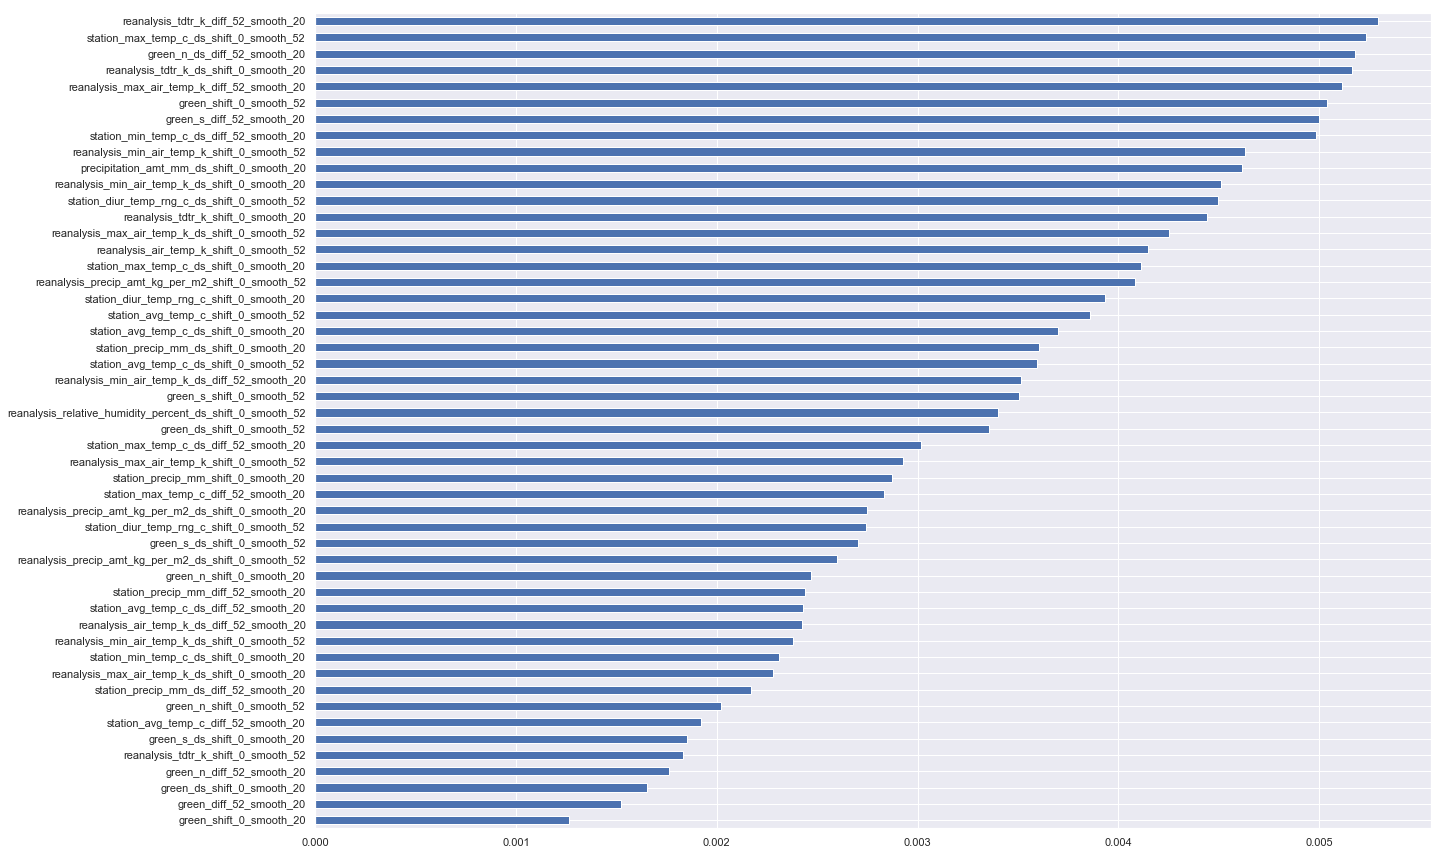

In [18]:
plt.figure(figsize = (20,15))
pd.Series(mdl_sj.feature_importances_,index = train_X_sj.columns).sort_values(ascending = True).iloc[:50].plot.barh()

###  Feature importances for IQ (Top 50)

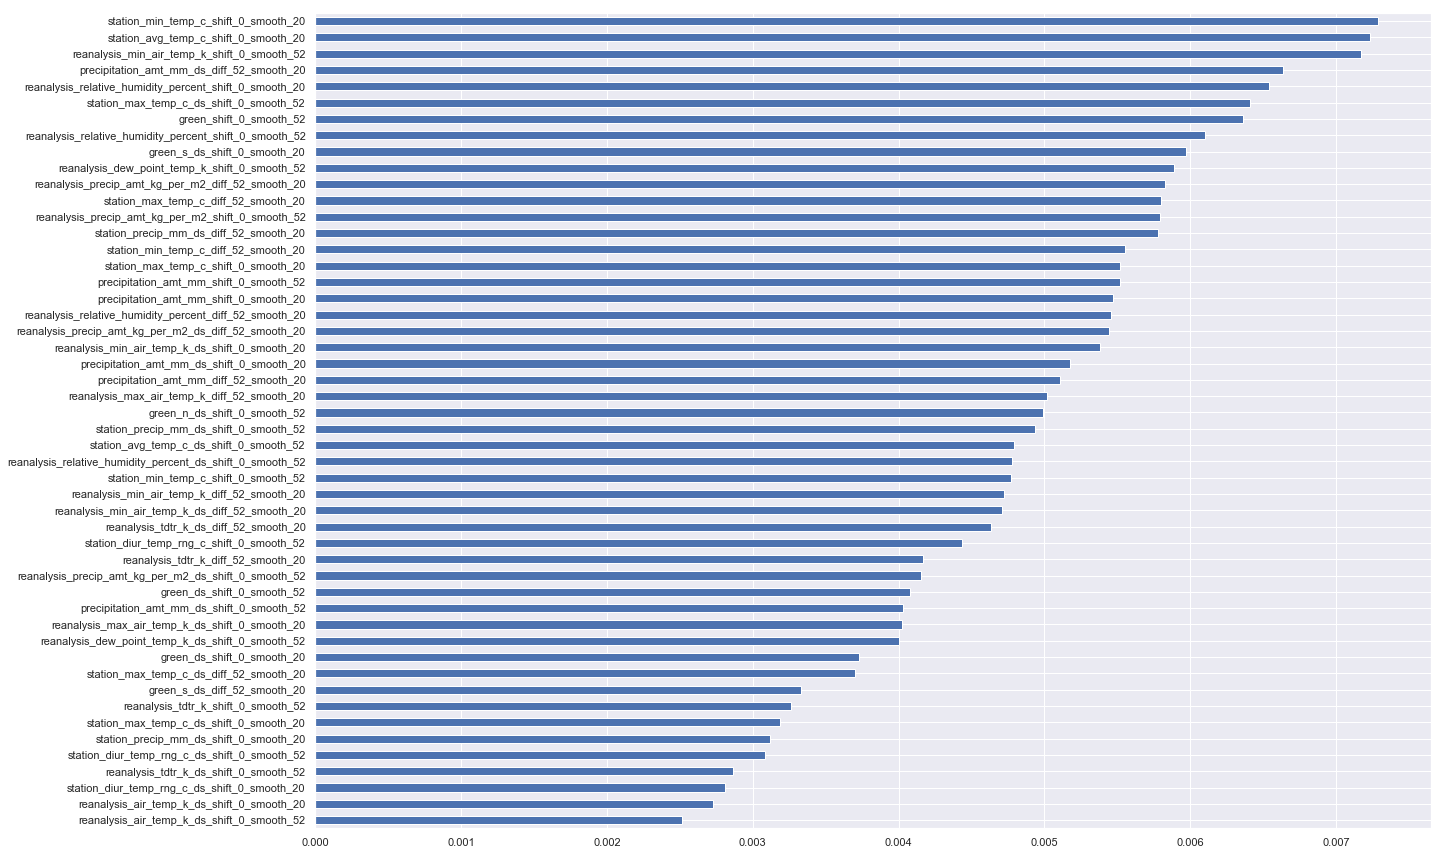

In [19]:
plt.figure(figsize = (20,15))
pd.Series(mdl_iq.feature_importances_,index = train_X_sj.columns).sort_values(ascending = True).iloc[:50].plot.barh()